## Introduction to Reinforcement Learning and Q-Learning

### The environment

In [ ]:
from rlboard import *

width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

### Actions and policy

In [ ]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

### Random walk

In [ ]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            print("Found an apple at", n)
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            print("Failed at", n)
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1
        # clear output
        clear_output(wait=True)
        m.plot()

In [46]:
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt        # <- only needed for titles
from IPython.core.display_functions import clear_output

def walk_with_animation(m, policy, delay=0.25, start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position
    else:
        m.random_start()
    while True:

        # --- draw the board ----------------------------------------------
        clear_output(wait=True)         # clear the previous frame
        m.plot()                        # your existing Board.plot()
        plt.title(f"Step {n}")          # optional: show step number
        plt.show()
        time.sleep(delay)               # pause so the frame is visible

        if m.at() == Board.Cell.apple:
            print("Found an apple at", n)
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            print("Failed at", n)
            return -1 # eaten by wolf or drowned
        hasBeenTo = m.at()
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            while True:
                if np.array_equal(new_pos, hasBeenTo):
                    a = actions[policy(m)]
                    new_pos = m.move_pos(m.human,a)
                else:
                    break
            print("new_pos: ", new_pos)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                hasBeenTo = new_pos
                break
        n+=1
        # clear output
        clear_output(wait=True)
        m.plot()

In [ ]:
# walk(m,random_policy)
walk_with_animation(m, random_policy, delay=0.8)


In [ ]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(2):
        # z = walk(m,policy)
        z = walk_with_animation(m, policy, delay=0.3)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
        m.plot()
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

### Reward function

In [ ]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

### Q-Learning

In [ ]:
# Create Q-Table.
Q = np.ones((width,height,len(actions)),dtype=np.float64) * 1.0/len(actions)

# m.plot(Q)
print(Q.min())
print(Q.max())
print(Q.sum())
print(Q[3,4])

In [ ]:
# Create a function probs():
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [ ]:
# Run them learning algorithm
lpath = []
for epoch in range(5000):
    # Pick initial point
    m.random_start()

    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            lpath.append(n)
            break
        alpha = np.exp(-n / 10e5)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

In [ ]:
m.plot(Q)
print(Q.min())
print(Q.max())
print(Q.sum())


### Checking the policy

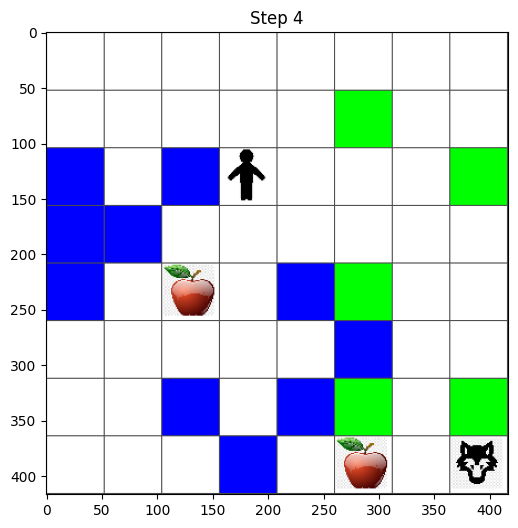

Found an apple at 4


4

In [57]:
def qpolicy_strict(m):
    x,y = m.human
    v = probs(Q[x,y])
    a = list(actions)[np.argmax(v)]
    return a

walk_with_animation(m,qpolicy_strict, delay=0.5, start_position=(5,4))